# Relativistic approximations of the Saha and Planck function in white dwarfs
 relatavstic statmechimcs in white dwarfs

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy
import astropy.constants as c
import astropy.units as u

import smplotlib

Bad value in file 'C:\\Users\\ericm\\smplotlib\\src\\smplotlib\\smplot.mplstyle', line 617 ("hist.bins: 'auto'  # The default number of histogram bins or 'auto'."): Key hist.bins: 'hist.bins' must be one of ['auto', 'sturges', 'fd', 'doane', 'scott', 'rice', 'sqrt'], an int or a sequence of floats


#### This verion of the $\mu$ is the boltzmann approximation withy no $\pm$ 1 

In [10]:
# T and n in log space 
T = np.logspace(10, 20, 100)
n = np.logspace(20, 30, 100)

A = c.h**3 *c.c**5 / (16*np.pi* c.k_B**3)
A = A.value
B = c.m_p**2 * c.c**4 
B = B.value



In [11]:
mu = np.log(A * n/T )*c.k_B.value*T  + B

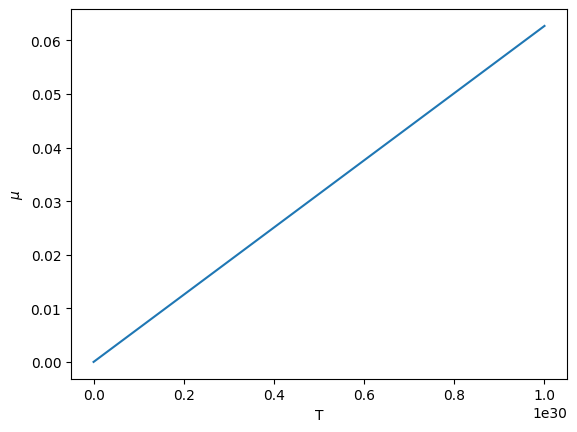

In [12]:
plt.plot(n, mu)

plt.xlabel('T')
plt.ylabel('$\mu$')
plt.show()


In [47]:
# version

n = np.logspace(20, 30, 100)
T = 100000 


A = (c.h**3 *c.c**5 * n) / (16*np.pi* (c.k_B*T)**3)
AA = np.log10(A.value) * c.k_B*T
AA = AA.cgs.value
BB = (c.m_p**2 * c.c**4).value - (c.m_p*c.c**2).value
BB = BB

mu_2 = AA + BB

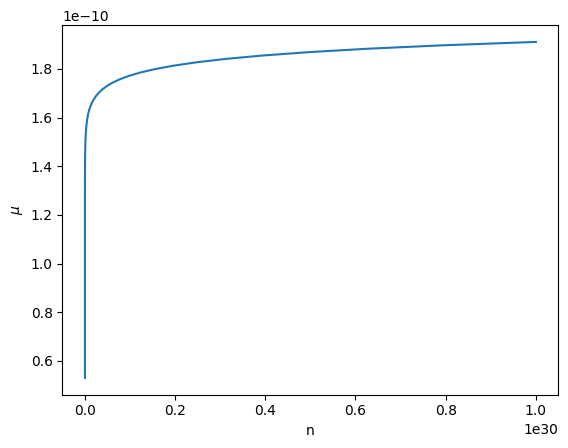

In [48]:
plt.plot(n, mu_2)


plt.xlabel('n')
plt.ylabel('$\mu$')
plt.show()


### Fermi-Dirac distribution of the electrons

# <center> $ n = \frac{8 \pi}{h^3} \int_0^\infty \frac{p^2 dp}{e^{ ( -\mu + mc^2\sqrt{1 + (p/mc)^2})/kT} + 1} $

In [40]:
import astropy.constants as c


In [8]:
# solve numerically the equation
# $ n = \frac{8 \pi}{h^3} \int_0^\infty \frac{p^2 dp}{e^{ ( -\mu + mc^2\sqrt{1 + (p/mc)^2})/kT} + 1} $

T = 100000
n = np.logspace(20, 30, 100)
def integrand(p, mu, T):
    AAA = (-mu + (c.m_p*c.c**2).value * np.sqrt(1 + (p/(c.m_p*c.c)).value**2)) / (c.k_B.value*T)
    exp = np.exp(AAA)
    return p**2 / (exp + 1)

def f(mu, T, n):
    return n - 8*np.pi/(c.h.value**3) * scipy.integrate.quad(integrand, 0, np.inf, args=(mu, T))[0]


# mu = scipy.optimize.brentq(f, -1e-10, 1e-10, args=(T, n[34]))

# use f solve to find mu
# mu = scipy.optimize.fsolve(f, 1e-10, args=(T, n[34]))

for i in np.logspace(10, 40, 100):
    #mu = scipy.optimize.fsolve(f, 442, args=(T, i))
    mu = scipy.optimize.brentq(f, 0.01, 1e50, args=(T, i))
    plt.plot(i, mu, 'o')

plt.xlabel('n')
plt.ylabel('$\mu$')

plt.show()


ValueError: f(a) and f(b) must have different signs

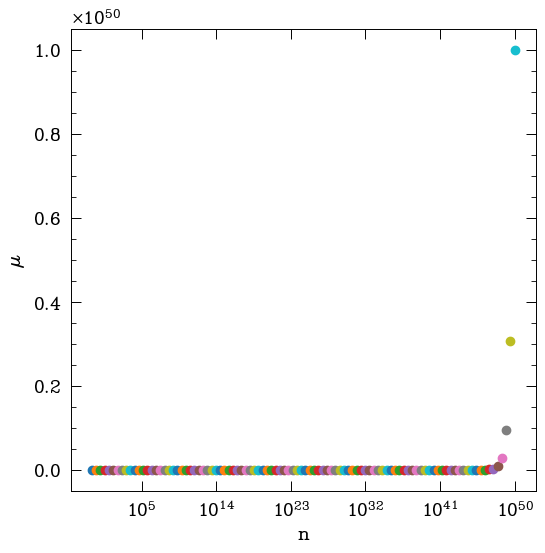

In [16]:
# plot f as a function of n 
# for different T

for i in np.logspace(-1, 50, 100):
    plt.plot(i, f(1e-10, 1e5, i) , 'o')

plt.xlabel('n')
plt.ylabel('$\mu$')
plt.xscale('log')

plt.show()


In [2]:
8*np.pi/(c.h**3)

<Quantity 8.63916505e+100 1 / (J3 s3)>

## Eric - September 26th

In [256]:
from astropy import table

def idealElectronPressure(n_e, k, T):
    return n_e * k * T

def fullyDegenElectronPressure_routine(n_e, mu_e, thresh):
    # TODO deal with case that the input is an array (causes errors with the inequalities)
    
    # Eqn 37 in Mike's notes
    p_max = (3 * n_e * c.h**3 / 8 / np.pi)**(1/3)
    
    # Non-relativistic case
    if p_max < thresh*c.m_e*c.c:
        # Eqn 43 in Mike's notes
        P_e = c.h**2 / 60 / np.pi**(2/3) / c.m_e * (3 * n_e)**(5/3)
        regime = 'NR'
        
    # Extreme-relativistic case
    elif thresh * p_max > c.m_e*c.c:
        # Eqn 45 in Mike's notes
        P_e = c.c * c.h / 24 / np.pi**(1/3) * (3 * n_e)**(4/3)
        regime = 'ER'
        
    # Intermediate densities
    else:
        # Eqn 47 in Mike's notes
        y = (p_max / c.m_e / c.c).si
        P_e = np.pi * c.m_e**4 * c.c**5 / 3 / c.h**3 * (y * (1 + y**2)**(1/2) * (2 * y**2 - 3) + 3 * np.arcsinh(y).value)
        regime = 'IN'
    
    # Note, if changing units here, update units parameter in fullyDegenElectronPressure for the QTable
    return [n_e.si, P_e.si, regime]

def fullyDegenElectronPressure(n_e, mu_e=2, thresh=0.001):
    # Note returns in cgs units, ie pressure in P/s
    
    # Check if input has multiple values ie np array, list, etc, all of which may have astropy units
    if type(n_e.value) == np.ndarray or type(n_e.value) == list:
        output = []
        for i, n in enumerate(n_e):
            output.append(fullyDegenElectronPressure_routine(n, mu_e, thresh))
        
        return table.QTable(np.asarray(output), names=['n_e', 'P_e', 'regime'], units=[1/u.m**3, u.N/u.m**2, None], dtype=['f8', 'f8', 'S2'], meta={'regime': ['non-relativistic', 'extreme-relativistic', 'intermediate']})     

    else:
        return fullyDegenElectronPressure_routine(n_e, mu_e, thresh)

In [259]:
fullyDegenElectronPressure(10**200 / u.cm ** 3)

[<Quantity 1.e+206 1 / m3>, <Quantity 1.13495125e+249 N / m2>, 'ER']

In [261]:
number_density_range = np.logspace(-100, 100, 100) / u.cm ** 3

fullyDegenElectronPressure(number_density_range)[0]['n_e']

<Quantity 1.e-94 1 / m3>

In [262]:
# Define our three regimes

NR_reg = fullyDegenElectronPressure(number_density_range)[fullyDegenElectronPressure(number_density_range)['regime'] == 'NR']
ER_reg = fullyDegenElectronPressure(number_density_range)[fullyDegenElectronPressure(number_density_range)['regime'] == 'ER']
IN_reg = fullyDegenElectronPressure(number_density_range)[fullyDegenElectronPressure(number_density_range)['regime'] == 'IN']

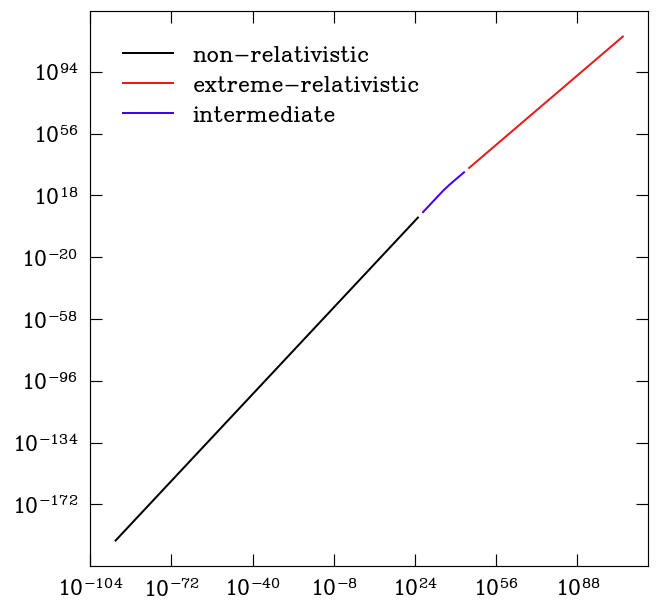

In [268]:
# Plot the three regimes as different colors
fig, ax = plt.subplots()

ax.plot(NR_reg['n_e'], NR_reg['P_e'], label='non-relativistic')
ax.plot(ER_reg['n_e'], ER_reg['P_e'], label='extreme-relativistic')
ax.plot(IN_reg['n_e'], IN_reg['P_e'], label='intermediate')

ax.set_yscale('log')
ax.set_xscale('log')
plt.legend()


In [232]:
list(zip(*[[1,2],[3,4],[5,6]]))

[(1, 3, 5), (2, 4, 6)]